# CS5831 Final Project Checkpoint Assignment
#### By: Connor Donahue

## Project Overview
### Project Title: Diabetes Determinants
This central focus of this project is to use medical data to develop a model that accurately predicts whether or not an individual has diabetes. In order to achieve this goal, I develop a tree ensemble classifier using the XGBoost algorithm. An additional step of hyperparameter tuning is utlilized to select the optimal choice of the number of trees used in the ensemble and the max depth of each tree. A series of other models are also created and evaluated in order to compare with the XGBoost model. Once the model is complete, it is intended to be used for predicting whether or not an individual has diabetes or may be at risk for contracting the disease.

## Imports 
The following cell imports various packages that will be used throughout the project

In [26]:
# Import standard Data Science packages 
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib.patches import Patch 
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy
import statistics
import textwrap
%matplotlib inline

# install xgboost package if not already installed
!pip install xgboost

from sklearn.model_selection import train_test_split, StratifiedKFold 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn import tree        # decision tree classifier
from sklearn import ensemble    # ensemble classifiers
from xgboost import XGBClassifier, plot_importance
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn import metrics     # performance evaluation metrics
from sklearn import model_selection
from sklearn import preprocessing 
from sklearn.feature_selection import SelectPercentile

## Data Acquisition and Preprocessing

- The following code cell loads the contents of 50/50 split csv from the Kaggle "Diabetes Health Indicators" dataset (the data set is also found in the UCI Machine Learning Repository) into a pandas dataframe. The data set contains various variables related to the health and socioeconomic status of 70,692 individuals, as well as a binary indicator variable that has the value of 1 if the individual has diabetes and 0 if not.

- There are no missing values in the data set, so there were no preprocessing steps performed to address missing values.

- The 50/50 split data is used, so there are no issues with class imbalances to address.

-  After loading the data into a dataframe, the feature variables and the target variable are separated into different data frames "diabetesX" and "diabetesY". Subsequently, a random stratified sample divides 80% of the data into the training + validation set and 20% into the testing set.

- In the last section of the code cell, the ordinal and numerical variables titled 'BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', and "Income" are scaled onto the range of 0 to 1. Although this step is not necessary for developing the tree ensemble, it is good practice to scale the data for use in other classifiers such as KNN or Naive Bayes. Min-max scaling onto the range (0,1) was used rather than standard scaling because most features in the data set are binary values and this would ensure that all features to have the same range of values.

Data Source (contains original data set and further information about features): https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset

In [27]:
# Read diabetes data set into dataframe
diabetes = pd.read_csv('diabetes_binary_5050split_health_indicators_BRFSS2015.csv', sep = ',') 

# Divide diabetes features and target into separate data frames
diabetesX = diabetes.iloc[:,1:22]
diabetesY = diabetes.iloc[:,0]

# split data into training + cross-validation and test sets. Using random state 42 for reproducibility 
X_trainval, X_test, y_trainval, y_test = train_test_split(diabetesX, diabetesY, test_size=0.2, stratify = diabetesY, random_state=42)

# Scale ordinal and interval variables
scaler = MinMaxScaler()
X_trainval[['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', "Income"]] = scaler.fit_transform(X_trainval[['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', "Income"]])
X_test[['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', "Income"]] = scaler.transform(X_test[['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', "Income"]])

## PCA Analysis
- In order to get an understanding for the variability in the data, I conducted a principal component analysis, reducing the dimensionality of the data to size 2.
- The results of the PCA are plotted below. The two most significant principal components do not explain enough of the variablilty of the data for easy cluster identification. This suggests that the diabetes classification task will require information from many features in the dataset and it may be challenging to construct an accurate classifier.  

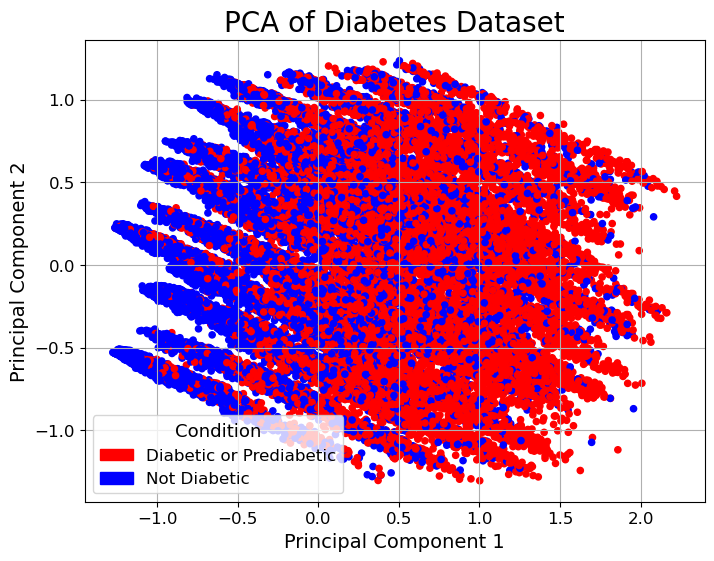

In [28]:
# run PCA, reducing data to 2 principal components
pca = PCA(n_components=2) 
X_pca = pca.fit_transform(X_trainval)
colors = np.where(y_trainval == 1, 'red', 'blue')

# Plotting the PCA Results
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors, s=20)
plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)
plt.title('PCA of Diabetes Dataset', fontsize=20)
plt.grid(True)
legend_elements = [
    Patch(facecolor='red', edgecolor='red', label='Diabetic or Prediabetic'),
    Patch(facecolor='blue', edgecolor='blue', label='Not Diabetic')
]
plt.legend(handles=legend_elements, title='Condition', title_fontsize=13, fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


## Modeling and Methodology
The following code cell fits the XGBoost Classification model to the training data set. The model is applied using various combination of the hyperparameters determining the maximum number of trees used in the ensemble (n_estimators) and the maximum depth of each invidiual tree (max_depth). 5-fold cross-validation using the Receiver Operating Characteristic Area Under the Curve (ROC AUC) metric is performed in order to evaluate each fitted model. 

In [29]:
# construct pipeline for running xgboost algorithm with various hyperparameter values
# the random state is set to 42 for reproducibility purposes
pipeline = Pipeline([
    ('xg', XGBClassifier(learning_rate = 0.1, random_state=42))
])

# params: hyper-parameters for the maximum number of trees in ensemble: [150, 175, 200, 225, 250],
#   and depth of each tree: [2, 3, 4, 5]
params = {
    'xg__n_estimators': [150, 175, 200, 225, 250],
    'xg__max_depth': [2, 3, 4, 5]
}

# Set the random state in the stratified 5-fold cv to 42 for reproducibility 
cvStrat = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Use ROC AUC as the scoring metric for the GridSearch criteria. 
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=params,
    cv=cvStrat,
    scoring='roc_auc'
)

# fit the grid of parameters to the training + validation set
grid.fit(X_trainval, y_trainval) 

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('xg',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      feature_weights=None...
                                                      learning_rate=0.1,
                                                      max_bin=None,
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             param_grid={'xg__max_depth': [2, 3, 4, 5],
                         'xg__n_estimators': [150, 175, 200, 225, 250]},
             scoring='roc_auc')

## Evaluation and Results
- The combination of hyperparameters with the highest ROC AUC score, as determined in the cross-validation step of the pipeline, is selected and the hyperparameter values and score are reported. These optimal hyperparameters are max_depth = 3 and n_estimators = 175.
- The model achieves a strong ROC AUC score of 0.83, which indicates that it can classify patients as diabetic or nondiabetic much more reliably than a random guess.
- The training + validation set was used to train a decision tree (DT) classifier, k-nearest neighbor (KNN) classifier, and naive bayes (NB) classifier. The bar plot comparing the ROC AUC scores of the XGBoost algorithm with the scores of other classifiers suggests the XGBoost is the best simple machine learning model for this task. Notably, the training of these other models did not involve any hyperparameter tuning. However, later analyses in this project demonstrate that hyperparameter tuning has little impact on the XGBoost ROC AUC score, which may be the case for other models as well.
- The additional test metrics of accuracy, precision, and recall were calculated in order to make comparisons between the XGBoost model and results from related literature. The model demonstrated moderate perfomance, achieving an accuracy of 0.75, precision of 0.73, and recall of 0.80.
- The final plot in the following cell plots the "gain" (reduction of log loss) of each feature. This metric reveals the importance of each feature in the model. Evidently, the "HighBP," "GenHlth," and "HighChol" features are most important to the model. This suggests that the additional lifestyle data such as "Smoker," "Fruits," and "Veggies" have little importance in classifying individuals by their diabetes diagnosis.

Best parameters: {'xg__max_depth': 3, 'xg__n_estimators': 175}
Test ROC AUC (XGBoost Classifier): 0.8304729417023509


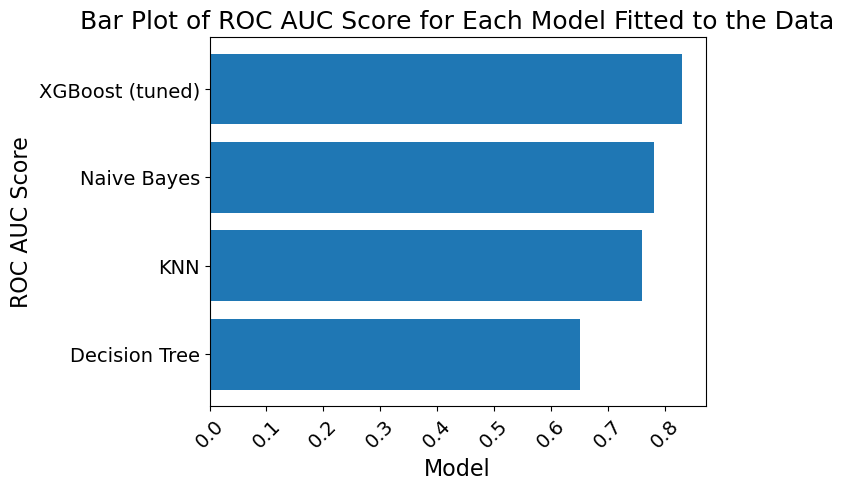

Accuracy: 0.7533064573166419
Precision: 0.7323212663812119
Recall: 0.7984156174847927


<Figure size 640x480 with 0 Axes>

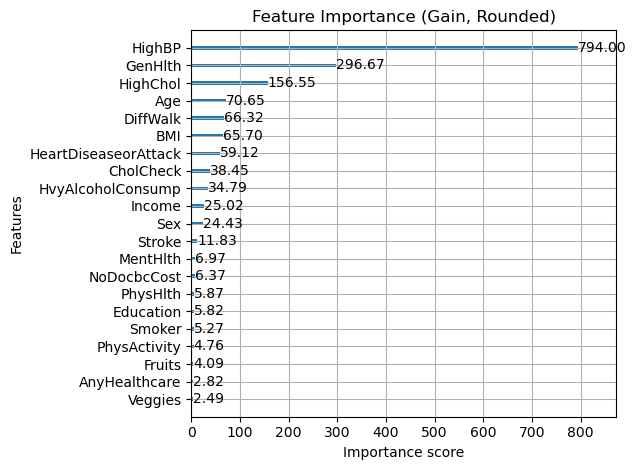

In [30]:
# Find the best hyperparameters
best_params = grid.best_params_

# Find the ROC AUC score of the best parameters on the test set
auc_test = metrics.roc_auc_score(y_test, grid.predict_proba(X_test)[:, 1])

# fit data to single decision tree to compare results 
# set random state to 42 for reproducability
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_trainval, y_trainval)
auc_tree = metrics.roc_auc_score(y_test, dt.predict_proba(X_test)[:, 1])

# fit data to KNN classifier to compare results, using k = 5
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_trainval, y_trainval)
auc_knn = metrics.roc_auc_score(y_test, knn.predict_proba(X_test)[:, 1])

# fit data to NB classifier to compare results
nb = BernoulliNB()
nb.fit(X_trainval, y_trainval)
auc_nb = metrics.roc_auc_score(y_test, nb.predict_proba(X_test)[:, 1])

# Print the best performing parameters and their ROC AUC score on the test data
print(f"Best parameters: {best_params}")
print(f"Test ROC AUC (XGBoost Classifier): {auc_test}")

# plot bar plot of score for performace comparison 
plt.figure()
plt.barh(width = [auc_tree, auc_knn, auc_nb, auc_test], y = ['Decision Tree', 'KNN', 'Naive Bayes', 'XGBoost (tuned)'])
plt.xticks(rotation=45)
plt.title("Bar Plot of ROC AUC Score for Each Model Fitted to the Data", fontsize=18)
plt.xlabel("Model", fontsize = 16)
plt.ylabel("ROC AUC Score", fontsize = 16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# calculate and print the model's accuracy, precision, and recall
y_pred = grid.predict(X_test)
acc = metrics.accuracy_score(y_test, y_pred)
pre = metrics.precision_score(y_test, y_pred)
re = metrics.recall_score(y_test, y_pred)
print(f"Accuracy: {acc}\nPrecision: {pre}\nRecall: {re}")


# plot the importance of each feature calculated by gain
plt.figure()
best_pipeline = grid.best_estimator_
xgb_model = best_pipeline.named_steps['xg']
booster = xgb_model.get_booster()
ax = plot_importance(booster, importance_type='gain', show_values=False)
plt.title("Feature Importance (Gain, Rounded)")
for bar in ax.patches:
    value = bar.get_width()
    rounded = round(value, 2)
    ax.text(value, bar.get_y() + bar.get_height()/2,
            f'{rounded:.2f}', va='center', ha='left')
plt.tight_layout()
plt.show()

## Visualization and Insight
- In the two scatter plots below, the cross-validation ROC AUC scores for each model are plotted against the number of trees in the ensemble and then the maximum depth of each tree.
- The plots show that the cross-validation ROC AUC scores range from 0.828 to just over 0.830, which suggests that the hyperparameter tuning has very little impact on the predictive strength of the model. Furthermore, there does not appear to be any significant maxima or trends in the plots to delineate a clearly optimal choice of hyperparameters.
- The final plot depicts the ROC curve for the model, showing the model's true postitive and false positive rates at different classification thresholds.

<Figure size 640x480 with 0 Axes>

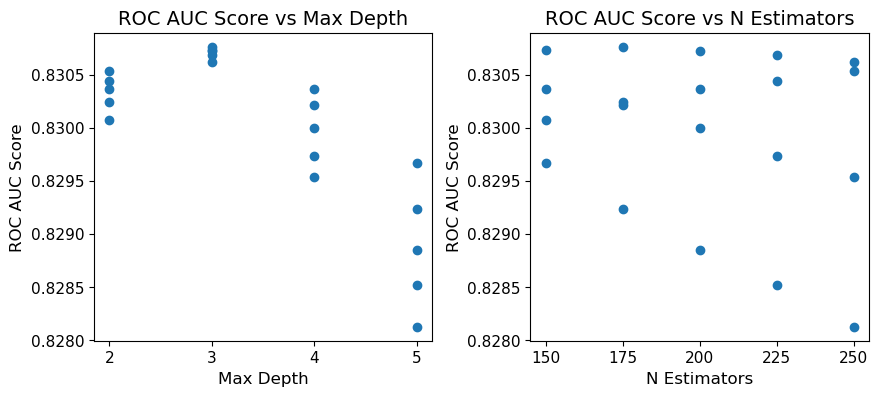

In [31]:
# Get cross validation results in a datafram
results_df = pd.DataFrame(grid.cv_results_)

# create plot figure
plt.figure()
fig, axes = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'wspace': 0.29})

# plot ROC AUC Score vs Max Depth
axes[0].scatter(results_df["param_xg__max_depth"], results_df['mean_test_score'])
axes[0].set_title('ROC AUC Score vs Max Depth', fontsize=14)
axes[0].set_xlabel('Max Depth', fontsize=12)
axes[0].set_ylabel('ROC AUC Score', fontsize=12)
axes[0].set_xticks([2,3,4,5])
axes[0].tick_params(axis='y', labelsize=11)
axes[0].tick_params(axis='x', labelsize=11)

# plot ROC AUC Score vs N Estimators
axes[1].scatter(results_df["param_xg__n_estimators"], results_df['mean_test_score'])
axes[1].set_title('ROC AUC Score vs N Estimators', fontsize=14)
axes[1].set_xlabel('N Estimators', fontsize=12)
axes[1].set_ylabel('ROC AUC Score', fontsize=12)
axes[1].set_xticks([150, 175, 200, 225, 250])
axes[1].tick_params(axis='y', labelsize=11)
axes[1].tick_params(axis='x', labelsize=11)
plt.show()

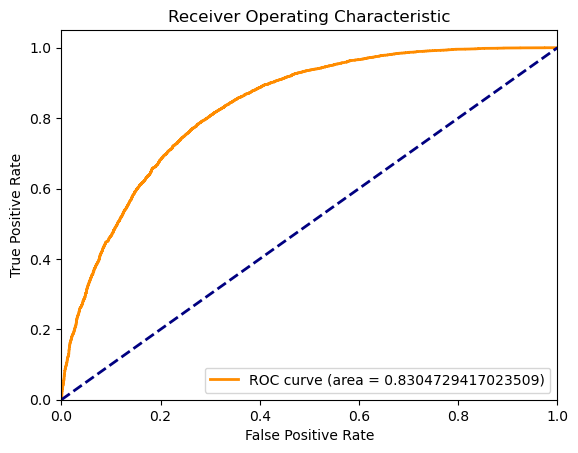

In [32]:
# get false positive rates and true positive rates for ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, grid.predict_proba(X_test)[:, 1])

# create plot figure 
plt.figure()

# plot ROC curve 
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_test})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Conclusion
The XGBoost model performs moderately well in the diabetes classification task, achieving a ROC AUC score of 0.83. This is a relatively strong performance for a simple tree-based classification model. Hyperparameter tuning was used to select the optimal values for the number of trees in the ensemble and maximum depth of each individual tree, although further analysis demstrated that the model performed similarly for all values of hyperparameters that were evaluated. Additionally, the XGBoost model outerperformed other classification models including DT, KNN, and NB.